## Import libraries and copy of dataset including extracted features

In [357]:
from PIL import Image, ImageFilter, ImageStat, ImageOps, ImageMorph, ImageMath
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy import signal
import pywt
from skimage.feature import greycomatrix,greycoprops 
from sklearn import svm, discriminant_analysis,neighbors,naive_bayes
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Load file names and labels
df = pd.read_csv('dataset/label_data.csv')    

# Task A

## Data preprocessing

### A histogram of the different classes in the training set reveals a large imbalance between tumourous and non-tumourous classes. This imbalance will produce an statistical bias of classifiers towards tumourous classes since selecting a new sample as tumourous has an underlying 75% probablity of being correct. 

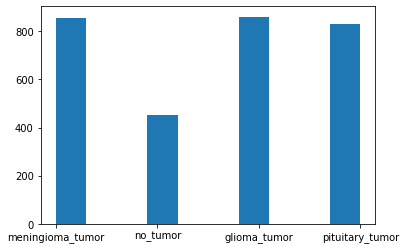

In [363]:
plt.hist(df['label'])
plt.show()

### The are two general ways in which imbalanced datasets can be handled. One option is to perform under-sampling of the dominant classes, this process ensures all remaining datapoints are real and a good representation of the class (subject to an unbiased sample removal) but implies reducing the size of the training data. Another option is to over-sample the minority class by either repeating existing datapoints or statiatically synthesising new points, this method increases the size of the training data but is not as accurate as under-sampling because the new datapoints are not real samples. It is also common to perform both methods sequentially to generate new points and then clear up the feature space.

### Given that the size of the training data is low (relative to deep learning techniques requirements) over-sampling was chosen as dataset balancing method. Particularly, the Support Vector Machine (SVM) variant of the Synthetic Minority Over-sampling Technique (SMOTE) algorithm was chosen as over-sampling method since it is designed to amplify the number of datapoints by connecting inliers and outliers in the minority class while giving a greater preference to outliers. SVMSMOTE ensures new datapoints are balanced but also harder to classify, hence implying that good results from classifiers will be due to correct feature selection rather than meaningless clearly separated samples. 

## Feature extraction

In [187]:
# Loop over all images and calculate simple initial features such as average pixel intensity, entropy, etc.
# avg = []
# ent = []
# var = []
# ratioh = []
# ratiov = []
# ratiod = []
# rms = []
# median = []
# for idx,filename in enumerate(df.loc[:,'file_name']):
#     im = Image.open('dataset/image/'+filename).convert('L')
#     ent.append(im.entropy())
#     avg.append(ImageStat.Stat(im).mean[0])
    # median.append(ImageStat.Stat(im).median[0])
#     var.append(ImageStat.Stat(im).var[0])
    # rms.append(ImageStat.Stat(im).rms[0])

#     im = np.array(im) # convert to numpy array
#     left=0
#     right=0
#     top=0
#     bottom=0
#     topd=0
#     bottomd=0
#     for j in range(0,512):
#         for k in range(0,512):
#             if k>=256:
#                 top = top+im[j,k]
#             else:
#                 bottom = bottom+im[j,k]
            
#             if j>=256:
#                 right = right+im[j,k]
#             else:
#                 left = left+im[j,k]
#             if j>k:
#                 topd = topd+im[j,k]
#             else:
#                 bottomd = bottomd+im[j,k]

#     ratiov.append(left/right)
#     ratioh.append(top/bottom)
#     ratiod.append(topd/bottomd)

# df['entropy'] = ent
# df['variance'] = var
# df['avg_pixel_intensity'] = avg
# df['median'] = median
# df['rms'] = rms
# df['Horizontal symmetry'] = ratioh
# df['Vertical symmetry'] = ratiov
# df['Diagonal symmetry'] = ratiod
df.to_csv('dataset/label_data.csv',index=False)

In [5]:
# Testing how correlation between example images from each perspective help classifying them - top correlation seems useful 
corr_front = []
corr_side = []
corr_top = []
side = Image.open('dataset/image/IMAGE_0000.jpg').convert('L')
front = Image.open('dataset/image/IMAGE_0011.jpg').convert('L')
top = Image.open('dataset/image/IMAGE_0001.jpg').convert('L')
for idx,filename in enumerate(df.loc[:150,'file_name']):
    im = Image.open('dataset/image/'+filename).convert('L')
    corr_front.append(np.mean(signal.correlate2d(np.array(front),np.array(im))))
    corr_side.append(np.mean(signal.correlate2d(np.array(side),np.array(im))))
    corr_top.append(np.mean(signal.correlate2d(np.array(top),np.array(im))))

df.loc[:150,'corr_front'] = corr_front
df.loc[:150,'corr_side'] = corr_side
df.loc[:150,'corr_top'] = corr_top

ax = df[df['perspective']=='top'].plot('corr_top','Horizontal symmetry',kind='scatter',color='green',label='Top')
df[df['perspective']=='side'].plot('corr_top','Horizontal symmetry',kind='scatter',color='red',ax=ax,label='Side')
df[df['perspective']=='front'].plot('corr_top','Horizontal symmetry',kind='scatter',color='blue',ax=ax,label='Front')


<AxesSubplot:xlabel='Horizontal symmetry', ylabel='dissimilarity_LH'>

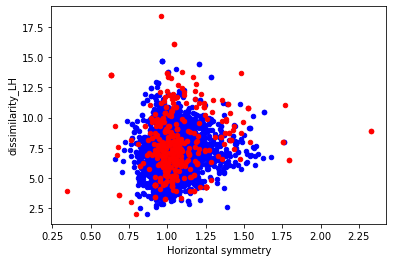

In [178]:
# Display images in feature space

healthy = df[df['tumour']==True]
sick = df[df['tumour']==False]
# front = df[df['perspective']=='front']

f1 = 'Horizontal symmetry'
f2 = 'dissimilarity_LH'
ax = healthy.plot(f1,f2,kind='scatter',color='blue')
sick.plot(f1,f2,kind='scatter',color='red',ax=ax)
# front.plot(f1,f2,kind='scatter',color='green',ax=ax)


## Image processing

In [186]:
feature1 = []
feature2 = []
feature3 = []
feature4 = []
feature5 = []
feature6 = []
for idx,filename in enumerate(df.loc[:,'file_name']):
    im = Image.open('dataset/image/'+filename).convert('L')
    im = np.array(im)
    _, (LH,HL,HH) = pywt.dwt2(im,'bior1.3')
    HH = ((HH - HH.min()) * (1/(HH.max() - HH.min()) * 255)).astype('uint8')
    glcm = greycomatrix(HH,distances=[5],angles=[0])
    feature1.append(greycoprops(glcm,prop='correlation')[0][0])
    feature2.append(greycoprops(glcm,prop='contrast')[0][0])
    feature3.append(greycoprops(glcm,prop='homogeneity')[0][0])
    feature4.append(greycoprops(glcm,prop='dissimilarity')[0][0])
    feature5.append(greycoprops(glcm,prop='ASM')[0][0])
    feature6.append(greycoprops(glcm,prop='energy')[0][0])

df['corr_HH'] = feature1
df['contrast_HH'] = feature2
df['homogeneity_HH'] = feature3
df['dissimilarity_HH'] = feature4
df['ASM_HH'] = feature5
df['energy_HH'] = feature6

## Classification

              precision    recall  f1-score   support

       False       0.62      0.51      0.56        77
        True       0.93      0.95      0.94       523

    accuracy                           0.90       600
   macro avg       0.77      0.73      0.75       600
weighted avg       0.89      0.90      0.89       600

              precision    recall  f1-score   support

       False       0.59      0.56      0.58        78
        True       0.94      0.94      0.94       522

    accuracy                           0.89       600
   macro avg       0.76      0.75      0.76       600
weighted avg       0.89      0.89      0.89       600

              precision    recall  f1-score   support

       False       0.66      0.54      0.59        82
        True       0.93      0.96      0.94       518

    accuracy                           0.90       600
   macro avg       0.79      0.75      0.77       600
weighted avg       0.89      0.90      0.89       600

              preci

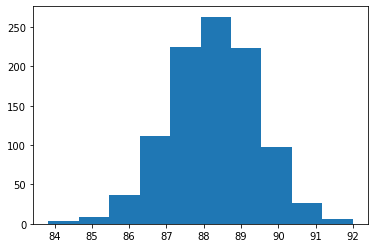

88.26633333333334 1.2095499162911785


In [361]:
# Create a feature matrix X(NxM) where N = number of data samples and M = number of features 
# Create a labels vector y(Nx1)

X = df.iloc[:,5:].to_numpy()
y = df['tumour']

acc = []
for i in range(0,1000):
    # k-fold splitting
    kf = KFold(n_splits=5,shuffle=True)
    kf.get_n_splits(X)
    for train_index, test_index in kf.split(X):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

    # SVM classifier training
    clf = discriminant_analysis.LinearDiscriminantAnalysis() # naive_bayes.GaussianNB() # neighbors.KNeighborsClassifier() # svm.SVC()
    clf.fit(X_train,y_train)

    # SVM classifier testing
    yhat = clf.predict(X_val)

    # Calculate accuracy
    correct = np.sum(yhat==y_val)
    acc.append(correct/len(y_val)*100)
    print(classification_report(y_val,yhat))
    
plt.hist(acc)
plt.show()
print(np.mean(acc),np.std(acc))
